# Description


# Packages

In [1]:
import numpy as np
from xarray import open_dataset
import matplotlib.pyplot as plt

In [2]:
def plot_interval(ax, xposition, interval, color, lw, w_bar=0.4, label=None, linestyle=None, markersize=10):
    center = np.mean(np.array(interval).flatten())
    error  = np.diff(np.array(interval).flatten())[0]/2
    interval = ax.errorbar(xposition, center, yerr=np.abs(error), color=color, capsize=20*w_bar, fmt="_",
                lw=lw, capthick=lw, markersize=markersize, label=label, linestyle=linestyle, clip_on=True, zorder=1000)
    return interval

In [3]:
from sklearn.linear_model import LinearRegression
def compute_trend_per_sample(data_perSample_perTime, times):
    nb_samples, nb_times = data_perSample_perTime.shape
    trend_per_sample     = np.nan*np.zeros(nb_samples)
    for id_sample in range(nb_samples):
        timeseries   = data_perSample_perTime[id_sample]
        notNan_times = np.logical_not(np.isnan(timeseries))
        trend        = LinearRegression().fit(times[notNan_times].reshape(-1, 1), timeseries[notNan_times]).coef_[0]
        trend_per_sample[id_sample] = trend

    return trend_per_sample

def compute_X_from_period(period, times, data_perSample_perTime, trend=False):
    times_to_keep = np.logical_and(period[0]<=times, times<=period[1])
    if not trend:
        X = np.nanmean(data_perSample_perTime[:, times_to_keep], axis=1)
    else:
        X = compute_trend_per_sample(data_perSample_perTime[:, times_to_keep], times[times_to_keep])
    return X


def compute_correlation_from_period(period, CMIP6_times, CMIP6_global_tas, Y, period_Y, trend=False):
    X = compute_X_from_period(period, CMIP6_times, CMIP6_global_tas, trend=trend)
    corr = np.corrcoef(X,Y)[0,1]
    if trend:
        print("the correlation between the global tas averaged in {}-{} and trend in {}-{} is : {:.2f}".format(
            period_Y[0], period_Y[1], period[0], period[1], corr))
    else:
        print("the correlation between the global tas averaged in {}-{} and averaged in {}-{} is : {:.2f}".format(
            period_Y[0], period_Y[1], period[0], period[1], corr))

In [79]:
from scipy.stats import t

def compute_confidence_intervals(X, X_obs, Y, confidence_level, period_Y, reference_period,
                                 display=True, return_for_different_x=False,
                                 neglect_M=False, impose_SNR=0, precomputed_Cov_N=0):
    M, K     = X.shape
    if neglect_M:
        M = 99999999
    mu_Y     = np.mean(Y)
    std_Y    = np.std(Y, ddof=1)
    mu_X     = np.mean(X, axis=0)
    mu_X_obs = np.mean(X_obs, axis=0)
    Cov_XY   = np.array([np.cov(Y, X[:, id_comp], rowvar=False, ddof=1)[0,1] for id_comp in range(K)])
    Cov_X    = np.cov(X, rowvar=False, ddof=1).reshape(K,K)
    

    if impose_SNR: # for special test, where you want a specific signal to nosie ratio (SNR)
        Cov_N = Cov_X / impose_SNR**2
    elif precomputed_Cov_N:
        Cov_N = precomputed_Cov_N
    else:
        Cov_N = np.cov(X_obs, rowvar=False, ddof=1)
        
    Cov_N = Cov_N.reshape(K,K)
    
    b1 = Cov_XY @ np.linalg.inv(Cov_X+Cov_N)
    b0 = mu_Y - b1 @ mu_X
    
    var_eps     = np.var(Y - b0 - X @ b1, ddof=1)
    sigma_eps_N = np.sqrt(var_eps + b1 @ Cov_N @ b1)
    root_term   = np.sqrt(1 + 1/M + (mu_X_obs-mu_X) @ np.linalg.inv(Cov_X+Cov_N) @ (mu_X_obs-mu_X)/M)

    constrained_CI   = b0 + np.matmul(b1, mu_X_obs) + np.array(t.interval(confidence_level, M-1-K, loc=0, scale=1))*sigma_eps_N*root_term
    unconstrained_CI = mu_Y + np.array(t.interval(confidence_level, M-1, loc=0, scale=1))*std_Y*np.sqrt(1+1/M)

    if display:
        print("{}% confidence:".format(int(100*confidence_level)))
        print("Global temperature at surface in {}-{} relative to {}-{}:".format(period_Y[0], period_Y[1], reference_period[0], reference_period[1]))
        print("Constrained : [{:.2f} +- {:.2f}]".format(np.mean(constrained_CI), np.diff(constrained_CI)[0]/2))
        print("Unconstrained : [{:.2f} +- {:.2f}]".format(np.mean(unconstrained_CI), np.diff(unconstrained_CI)[0]/2))

    if return_for_different_x:
        array_x = np.linspace(np.min((X.min(), mu_X_obs.min())), np.max((mu_X_obs.max(), X.max())), 100)
        constrained_CI_per_x = np.zeros((len(array_x), 2))
        for id_x in range(len(array_x)):
            mu_X_obs = array_x[id_x].reshape(-1,1)
            root_term  = np.sqrt(1 + 1/M + (mu_X_obs-mu_X) @ np.linalg.inv(Cov_X+Cov_N) @ (mu_X_obs-mu_X)/M)
            constrained_CI_per_x[id_x, :] = b0 + np.matmul(b1, mu_X_obs) + np.array(t.interval(confidence_level, M-1-K, loc=0, scale=1))*sigma_eps_N*root_term
        
        return constrained_CI, unconstrained_CI, array_x, constrained_CI_per_x
        
    return constrained_CI, unconstrained_CI


    

In [5]:

def compute_Cox_confidence_intervals(X, X_obs, Y, confidence_level, var_N):
    M     = len(X)
    mu_Y  = np.mean(Y)
    mu_X  = np.mean(X)
    var_X = np.var(X, ddof=1)
    
    lr = LinearRegression().fit(X, Y)
    coefs = lr.coef_
    estimated_value = lr.predict(X_obs.reshape(1, -1))
    
    z         = t.interval(confidence_level, np.inf, loc=0, scale=1)[1]
    var_eps   = np.var(Y - lr.predict(X), ddof=1)
    sample_uncertainty = 1 + 1/M + (X_obs-mu_X)**2 / (M * var_X)
    proj_var_noise = coefs**2 * var_N


    total_uncertainty = z*np.sqrt(var_eps * sample_uncertainty + proj_var_noise)

    constrained_CI   = (estimated_value + np.array([-total_uncertainty, total_uncertainty])).flatten()
    #unconstrained_CI = mu_Y + np.array([-total_uncertainty, total_uncertainty])*std_Y*np.sqrt(1+1/M)
    return constrained_CI


# Choice of the reference period (anomalies)

In [6]:
reference_period = [1850, 1900]

# Data importation
## Values from simulations (CMIP6 climate models)
Precomputed global temperature at the surface of the globe, for each year between 1850 and 2100, and for each available climate model.

In [7]:
# Import the data for each model, each year and each spatial position
CMIP6_name_models = np.load("../data/ssp245_timeserie_global_tas/name_models.npy")
CMIP6_times       = np.load("../data/ssp245_timeserie_global_tas/times.npy").astype(str).astype(int)
CMIP6_global_tas  = np.load("../data/ssp245_timeserie_global_tas/data.npy")- 273.15
print("there is {} climate models".format(len(CMIP6_name_models)))


# Work with anomalies
X_ref = compute_X_from_period(reference_period, CMIP6_times, CMIP6_global_tas)
CMIP6_global_tas -= X_ref.reshape(-1,1)

there is 32 climate models


## Values from observations (HadCRUT5)
HadCRUT5 analysis time series: ensemble members, global, annual, NetCDF
(*https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/download.html*)

These data are relative to 1961-1990

In [8]:
path = "../data/HadCRUT.5.0.2.0.analysis.ensemble_series.global.annual.nc"
data_HadCrut5 = open_dataset(path)

In [9]:
time_HadCrut5 = data_HadCrut5.time.data.astype("datetime64[Y]").astype(str).astype(int)
print(time_HadCrut5.min(), time_HadCrut5.max())

1850 2025


In [10]:
global_tas_obs_perRealisation_perTime = data_HadCrut5["tas"].data
print("there is {} realisations".format(global_tas_obs_perRealisation_perTime.shape[0]))

X_ref_obs = compute_X_from_period(reference_period, time_HadCrut5, global_tas_obs_perRealisation_perTime)
global_tas_obs_perRealisation_perTime -= X_ref_obs.reshape(-1,1)

there is 200 realisations


# Definition of Y
for some models, the 4 last years before 2100 are missing. This is why we take the period 2086-2095.

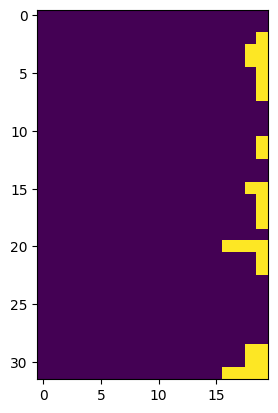

In [11]:
plt.imshow(np.isnan(CMIP6_global_tas)[:, -20:])

In [12]:
period_Y = [2091, 2100]

Y = compute_X_from_period(period_Y, CMIP6_times, CMIP6_global_tas)

# Inter-model correlation for different times period

In [13]:
compute_correlation_from_period([1850, 1975], CMIP6_times, CMIP6_global_tas, Y, period_Y)
compute_correlation_from_period([1975, 2014], CMIP6_times, CMIP6_global_tas, Y, period_Y)
compute_correlation_from_period([2015, 2024], CMIP6_times, CMIP6_global_tas, Y, period_Y)

the correlation between the global tas averaged in 2091-2100 and averaged in 1850-1975 is : 0.18
the correlation between the global tas averaged in 2091-2100 and averaged in 1975-2014 is : 0.44
the correlation between the global tas averaged in 2091-2100 and averaged in 2015-2024 is : 0.77


In [14]:
compute_correlation_from_period([1850, 1975], CMIP6_times, CMIP6_global_tas, Y, period_Y, trend=True)
compute_correlation_from_period([1975, 2014], CMIP6_times, CMIP6_global_tas, Y, period_Y, trend=True)
compute_correlation_from_period([2015, 2024], CMIP6_times, CMIP6_global_tas, Y, period_Y, trend=True)

the correlation between the global tas averaged in 2091-2100 and trend in 1850-1975 is : 0.19
the correlation between the global tas averaged in 2091-2100 and trend in 1975-2014 is : 0.69
the correlation between the global tas averaged in 2091-2100 and trend in 2015-2024 is : 0.30


# Three different choice of X:
1. mean 2015-2024 (univariate)
2. trend 1975-2014 (univariate)
3. both (multivariate)

In [15]:
period_X1 = [2015, 2024]
period_X2 = [1975, 2014]

In [16]:
# First choice
X1        = compute_X_from_period(period_X1, CMIP6_times, CMIP6_global_tas).reshape(-1,1)
X1_obs    = compute_X_from_period(period_X1, time_HadCrut5, global_tas_obs_perRealisation_perTime).reshape(-1,1)

# Second choice
X2        = compute_X_from_period(period_X2, CMIP6_times, CMIP6_global_tas, trend=True).reshape(-1,1)
X2_obs    = compute_X_from_period(period_X2, time_HadCrut5, global_tas_obs_perRealisation_perTime, trend=True).reshape(-1,1)

# Third choice
X3        = np.concatenate((X1, X2), axis=1)
X3_obs    = np.concatenate((X1_obs, X2_obs), axis=1)

### Test if the distributions are normals

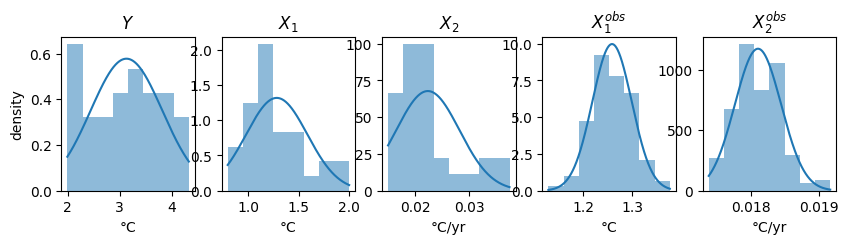

In [230]:
import scipy.stats as stats
def plot_histogram(ax, X, color="tab:blue", alpha=0.5, label="multi-model"):
    if len(label):
        label_hist = label+" density histogram"
        label_line = label+" fitted gaussian"
    else:
        label_hist, label_line = "", ""
    x = np.linspace(X.min(), X.max(), 2000)
    pdf = stats.norm.pdf(x, np.mean(X), np.std(X))
    hist = ax.hist(X, density=True, color=color, alpha=alpha, label=label_hist, bins=8)
    line = ax.plot(x, pdf, color=color, label=label_line)
    return hist, line
    
list_X = [Y, X1.flatten(), X2.flatten(), X1_obs.flatten(), X2_obs.flatten()]
list_X_name = [r"$Y$", r"$X_1$", r"$X_2$", r"$X_1^{obs}$", r"$X_2^{obs}$"]
list_units  = ["°C", "°C", "°C/yr", "°C", "°C/yr"]

fig, axes = plt.subplots(1, len(list_to_display), figsize=(10,2))
for i, ax in zip(np.arange(len(list_to_display)), axes.flatten()):
    plot_histogram(ax, list_X[i])
    ax.set_title(list_X_name[i])
    if i==0:
        ax.set_ylabel("density")
    #ax.set_yticks([])
    ax.set_xlabel(list_units[i])



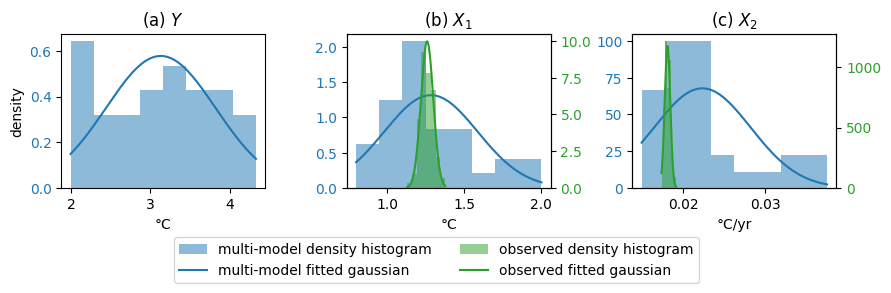

In [232]:
color1 = "tab:blue"
color2 = "tab:green"

fig, axes = plt.subplots(1, 3, figsize=(10,2))
ax = axes.flatten()[0]
hist, line = plot_histogram(ax, Y, color=color1, label="")
ax.set_title("(a) "+r"$Y$")
ax.tick_params(axis='y', labelcolor=color1)
ax.set_ylabel("density")
ax.set_xlabel("°C")

ax = axes.flatten()[1]
ax2 = ax.twinx()
plot_histogram(ax, X1, color=color1, label="")
plot_histogram(ax2, X1_obs, color=color2, label="")
ax.set_title("(b) "+r"$X_1$")
ax.tick_params(axis='y', labelcolor=color1)
ax2.tick_params(axis='y', labelcolor=color2)
ax.set_xlabel("°C")

ax = axes.flatten()[2]
ax2 = ax.twinx()
plot_histogram(ax, X2, color=color1, label="multi-model")
plot_histogram(ax2, X2_obs, color=color2, label="observed")
ax.tick_params(axis='y', labelcolor=color1)
ax2.tick_params(axis='y', labelcolor=color2)
ax.set_title("(c) "+r"$X_2$")
ax.set_xlabel("°C/yr")

plt.subplots_adjust(wspace=0.4)
fig.legend(bbox_to_anchor=(0.5, -0.1), ncols=2, loc='upper center')
plt.show()



In [17]:
print("\n\n------First choice:")
[constrained_CI_1, unconstrained_CI, array_x1, constrained_CI_per_x1
] = compute_confidence_intervals(X1, X1_obs, Y, 0.90, period_Y, reference_period, return_for_different_x=True)

print("\n\n------Second choice:")
[constrained_CI_2, unconstrained_CI, array_x2, constrained_CI_per_x2
] = compute_confidence_intervals(X2, X2_obs, Y, 0.90, period_Y, reference_period, return_for_different_x=True)

print("\n\n------Third choice:")
constrained_CI_3, unconstrained_CI = compute_confidence_intervals(X3, X3_obs, Y, 0.90, period_Y, reference_period)



------First choice:
90% confidence:
Global temperature at surface in 2091-2100 relative to 1850-1900:
Constrained : [3.09 +- 0.79]
Unconstrained : [3.13 +- 1.21]


------Second choice:
90% confidence:
Global temperature at surface in 2091-2100 relative to 1850-1900:
Constrained : [2.79 +- 0.88]
Unconstrained : [3.13 +- 1.21]


------Third choice:
90% confidence:
Global temperature at surface in 2091-2100 relative to 1850-1900:
Constrained : [2.91 +- 0.70]
Unconstrained : [3.13 +- 1.21]


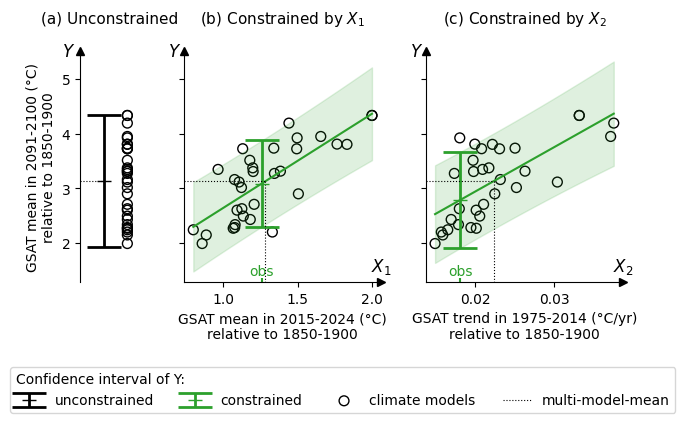

In [18]:
# Display parameters
fontsize = 12
lw_low  = 2
lw_high = 3
w_bar_wrong = 0.4
w_bar_right = 0.6
w_bar_true  = 0.6
alpha = 0.15
label3 = r"$CI_{90\%}(Y|X^N=x_0^N)$"

def display_X_Y_relation(ax, X, Y, X_obs, constrained_CI, constrained_CI_per_x, array_x):
    markers = ax.scatter(X, Y, label="climate models", s=50, marker="o", facecolor='none', edgecolors="black")
    #ax.set_xticks([np.mean(X), np.mean(X_obs)], labels=["multi-model-mean", "observation"], fontsize=fontsize, rotation=45, ha='right')
    interval = plot_interval(ax, np.mean(X_obs), constrained_CI, "tab:green", lw_low, w_bar=w_bar_right, label=label3)
    
    ax.fill_between(array_x, constrained_CI_per_x[:,0], constrained_CI_per_x[:,1],
                         alpha=alpha, color="tab:green")
    ax.plot(array_x, np.mean(constrained_CI_per_x, axis=1), color="tab:green",
             linewidth=lw_high/2, linestyle='solid', label=r"$y=\hat{b}_0+\hat{b}_1\,x$")
    return markers, interval

    

def display_arrows_axes(ax, remove_x=False, label_X=r"$X$"):
    # remove the top and right axe
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if remove_x:
        ax.spines['bottom'].set_visible(False)
    
    # display an arrow in the x and y axis
    xmin,xmax=np.copy(ax.get_xlim())
    ymin,ymax=np.copy(ax.get_ylim())
    if not remove_x:
        ax.plot((1), (0), ls="", marker=">", ms=6, color="k", 
                    clip_on=False, transform = ax.transAxes)
        
    ax.plot((0), (1), ls="", marker="^", ms=6, color="k",
            clip_on=False, transform = ax.transAxes)
    ax.set_xlim(xmin,xmax)

    # name of the axes
    
    if not remove_x:
        ax.text(1,0.07, label_X,
             ha='center', va='center',
             transform = ax.transAxes, fontsize=fontsize)
        ax.text(-0.05,1.0, r"$Y$",
         ha='center', va='center',
         transform = ax.transAxes, fontsize=fontsize)
    else:
        ax.text(-0.2,1.0, r"$Y$",
         ha='center', va='center',
         transform = ax.transAxes, fontsize=fontsize)



fig, axes = plt.subplots(1,3, figsize=(7,3), sharey=True, width_ratios=[0.3, 1,1])

#--------------- First axe: the unconstrained interval
axes[0].scatter(2*np.ones(len(Y)), Y, label="climate models", s=50, marker="o", facecolor='none', edgecolors="black", alpha=1)
interval_unconstrained = plot_interval(axes[0], 0, unconstrained_CI, "black", lw_low, w_bar=w_bar_right, label=r"$CI_{90\%}(Y)$")
axes[0].set_xlim(-2, 3)
axes[0].set_xticks([])

#--------------- Second and third axes: intervals constrained by X1 and X2
markers, interval_constrained = display_X_Y_relation(axes[1], X1, Y, X1_obs, constrained_CI_1, constrained_CI_per_x1, array_x1)
markers, interval_constrained = display_X_Y_relation(axes[2], X2, Y, X2_obs, constrained_CI_2, constrained_CI_per_x2, array_x2)

# Label the axes
axes[1].set_xlabel("GSAT mean in {}-{} (°C)\nrelative to {}-{}".format(period_X1[0], period_X1[1], reference_period[0], reference_period[1]))
axes[2].set_xlabel("GSAT trend in {}-{} (°C/yr)\nrelative to {}-{}".format(period_X2[0], period_X2[1], reference_period[0], reference_period[1]))
axes[0].set_ylabel("GSAT mean in {}-{} (°C)\nrelative to {}-{}".format(period_Y[0], period_Y[1], reference_period[0], reference_period[1]))


# Vertical lines corresponding to the mean
ymin, ymax = axes[0].get_ylim()
for i, x in zip([1,2], [np.mean(X1), np.mean(X2)]):
    axes[i].vlines(x, ymin=0, ymax=np.mean(unconstrained_CI), linestyle='dotted',
               color="black", linewidth=0.8, zorder=1000, alpha=1)
axes[0].set_ylim(ymin, ymax)

if False:
    # Horizontal and vertical lines corresponding to the constrained values
    for i, constrained_CI, X_obs in zip([1,2], [constrained_CI_1, constrained_CI_2], [X1_obs, X2_obs]):
        xmin, xmax = axes[i].get_xlim()
        axes[i].hlines(np.mean(constrained_CI), linestyle='dotted', xmin=xmin, xmax=np.mean(X_obs),
                       colors="tab:green", linewidth=0.8, zorder=10000, alpha=0.5, clip_on=False)
        axes[i].set_xlim(xmin, xmax)


# Horizontal lines corresponding to the unconstrained value
line_MMM = axes[0].hlines(np.mean(unconstrained_CI), linestyle='dotted', xmin=-2, xmax=0,
               colors="black", linewidth=0.8, zorder=10000, alpha=1, clip_on=False)
for i, X in zip([1,2], [X1,X2]):
    xmin, xmax = axes[i].get_xlim()
    axes[i].hlines(np.mean(unconstrained_CI), linestyle='dotted', xmin=xmin, xmax=np.mean(X),
                   colors="black", linewidth=0.8, zorder=10000, alpha=1, clip_on=False)
    axes[i].set_xlim(xmin, xmax)
    

# Display arrows in the axes
display_arrows_axes(axes[0], remove_x=True)
display_arrows_axes(axes[1], label_X=r"$X_1$")
display_arrows_axes(axes[2], label_X=r"$X_2$")

# Display the multi-model mean and observation in the x axis
for i, X_obs in zip([1,2], [X1_obs, X2_obs]):
    axes[i].text(np.mean(X_obs), ymin+0.2, "obs", ha='center', va='center', color="tab:green")
    axes[i].vlines(np.mean(X_obs), ymin=ymin-0.5, ymax=ymin+0.08, color="tab:green")

leg = fig.legend([interval_unconstrained, interval_constrained, markers, line_MMM],
           ["unconstrained", "constrained", "climate models", "multi-model-mean"],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, title="Confidence interval of Y:")
leg._legend_box.align = "left"

# Titles
axes[0].set_title("(a) Unconstrained", pad=20, fontsize=11)
axes[1].set_title("(b) Constrained by "+r"$X_1$", pad=20, fontsize=11)
axes[2].set_title("(c) Constrained by "+r"$X_2$", pad=20, fontsize=11)

plt.subplots_adjust(wspace=0.3)#, top=0.2)

plt.show()

In [19]:
np.mean(X2_obs)

0.018099968722909275

# Comparison with existing methods
## Methods "Bayesian" (Bowman et al. (2018), Ribes et al. (2021))
These methods lead to the same interval as our, with the difference to neglecting the fact that there is a limited number of climate models M.

## Method linear from Cox et al. (2018)
Cox et al. obtain an estimate and uncertainty of:
- $\hat{a}_0 + \hat{a}_1 \,x_0$
- $z\, \sqrt{\sigma_{\varepsilon}^2 \, (1+\frac{1}{M} + \frac{(x_0 - \hat{\mu}_X)^2}{M\,\hat{\sigma}_X^2}) + a_1^2 \, \sigma_N^2}$

Where with our framework we have:
- $\hat{b}_0 + \hat{b}_1 \,x_0$
- $t^{M-2} \, \sigma_{\varepsilon^N} \, \sqrt{1+\frac{1}{M} + \frac{(x_0 - \hat{\mu}_X)^2}{M\,(\hat{\sigma}_X^2+\sigma_X^2)}}$

z and t are gaussian and student quantiles. The main difference is that Cox et al. 2018 considers the regression of $X$ on $Y$, while we consider the regression of $X^N$ (observational noise) on $Y$:
- $Y = a_0 + a_1\,X + \varepsilon$
- $Y = b_0 + b_1\,X^N + \varepsilon^N$


In the example of $X_1$ that constraint Y, we obtain:

In [20]:
print("Our result:")
[constrained_CI_1, unconstrained_CI, array_x1, constrained_CI_per_x1
] = compute_confidence_intervals(X1, X1_obs, Y, 0.90, period_Y, reference_period, return_for_different_x=True)

Our result:
90% confidence:
Global temperature at surface in 2091-2100 relative to 1850-1900:
Constrained : [3.09 +- 0.79]
Unconstrained : [3.13 +- 1.21]


In [21]:
print("Result neglecting the limited sample size:")
[constrained_CI_1, unconstrained_CI, array_x1, constrained_CI_per_x1
] = compute_confidence_intervals(X1, X1_obs, Y, 0.90, period_Y, reference_period, return_for_different_x=True, neglect_M=True)

Result neglecting the limited sample size:
90% confidence:
Global temperature at surface in 2091-2100 relative to 1850-1900:
Constrained : [3.09 +- 0.75]
Unconstrained : [3.13 +- 1.15]


In [22]:
print("result obtained using the method from Cox et al. 2018:")

var_N = np.var(X1_obs, ddof=1)
constrained_CI = compute_Cox_confidence_intervals(X1, np.mean(X1_obs).reshape(-1,1), Y, 0.9, var_N)

print("Constrained : [{:.2f} +- {:.2f}]".format(np.mean(constrained_CI), np.diff(constrained_CI)[0]/2))

result obtained using the method from Cox et al. 2018:
Constrained : [3.09 +- 0.76]


In [23]:
SNR = np.std(X1)/np.std(X1_obs)
SNR

7.577456345407885

# The same with only 10 models

In [24]:
print("Our result:")
[constrained_CI_1, unconstrained_CI, array_x1, constrained_CI_per_x1
] = compute_confidence_intervals(X1[-5:], X1_obs, Y[-5:], 0.90, period_Y, reference_period, return_for_different_x=True)

Our result:
90% confidence:
Global temperature at surface in 2091-2100 relative to 1850-1900:
Constrained : [3.21 +- 0.90]
Unconstrained : [2.71 +- 2.04]


In [25]:
print("Result neglecting the limited sample size:")
[constrained_CI_1, unconstrained_CI, array_x1, constrained_CI_per_x1
] = compute_confidence_intervals(X1[-5:], X1_obs, Y[-5:], 0.90, period_Y, reference_period, return_for_different_x=True, neglect_M=True)

Result neglecting the limited sample size:
90% confidence:
Global temperature at surface in 2091-2100 relative to 1850-1900:
Constrained : [3.21 +- 0.56]
Unconstrained : [2.71 +- 1.44]


In [26]:
print("result obtained using the method from Cox et al. 2018:")

var_N = np.var(X1_obs, ddof=1)
constrained_CI = compute_Cox_confidence_intervals(X1[-5:], np.mean(X1_obs).reshape(-1,1), Y[-5:], 0.9, var_N)

print("Constrained : [{:.2f} +- {:.2f}]".format(np.mean(constrained_CI), np.diff(constrained_CI)[0]/2))

result obtained using the method from Cox et al. 2018:
Constrained : [3.23 +- 0.62]


# The same but with a SNR=1

In [52]:
SNR = 0.1

In [53]:
print("Our result:")
[constrained_CI_1, unconstrained_CI, array_x1, constrained_CI_per_x1
] = compute_confidence_intervals(X1, X1_obs, Y, 0.90, period_Y, reference_period, return_for_different_x=True, impose_SNR=SNR)

Our result:
90% confidence:
Global temperature at surface in 2091-2100 relative to 1850-1900:
Constrained : [3.13 +- 1.21]
Unconstrained : [3.13 +- 1.21]


In [54]:
print("Result neglecting the limited sample size:")
[constrained_CI_1, unconstrained_CI, array_x1, constrained_CI_per_x1
] = compute_confidence_intervals(X1, X1_obs, Y, 0.90, period_Y, reference_period, return_for_different_x=True, neglect_M=True, impose_SNR=SNR)

Result neglecting the limited sample size:
90% confidence:
Global temperature at surface in 2091-2100 relative to 1850-1900:
Constrained : [3.13 +- 1.15]
Unconstrained : [3.13 +- 1.15]


In [55]:
print("result obtained using the method from Cox et al. 2018:")

var_N = np.var(X1, ddof=1) / SNR**2
constrained_CI = compute_Cox_confidence_intervals(X1, np.mean(X1_obs).reshape(-1,1), Y, 0.9, var_N)

print("Constrained : [{:.2f} +- {:.2f}]".format(np.mean(constrained_CI), np.diff(constrained_CI)[0]/2))

result obtained using the method from Cox et al. 2018:
Constrained : [3.09 +- 8.87]


# Test : what is happening if we add a bias in climate models

In [65]:
np.corrcoef(X1.flatten(), Y)[0,1]

0.7664076922254656

90% confidence:
Global temperature at surface in 2091-2100 relative to 1850-1900:
Constrained : [3.09 +- 0.79]
Unconstrained : [3.13 +- 1.21]


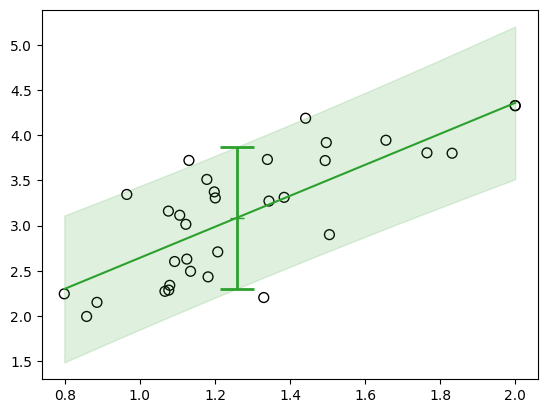

In [70]:
[constrained_CI_1, unconstrained_CI, array_x1, constrained_CI_per_x1
] = compute_confidence_intervals(X1, X1_obs, Y, 0.90, period_Y, reference_period, return_for_different_x=True)

fig, ax = plt.subplots(1,1)

markers, interval_constrained = display_X_Y_relation(ax, X1, Y, X1_obs, constrained_CI_1, constrained_CI_per_x1, array_x1)


90% confidence:
Global temperature at surface in 2091-2100 relative to 1850-1900:
Constrained : [2.37 +- 0.91]
Unconstrained : [4.13 +- 1.21]


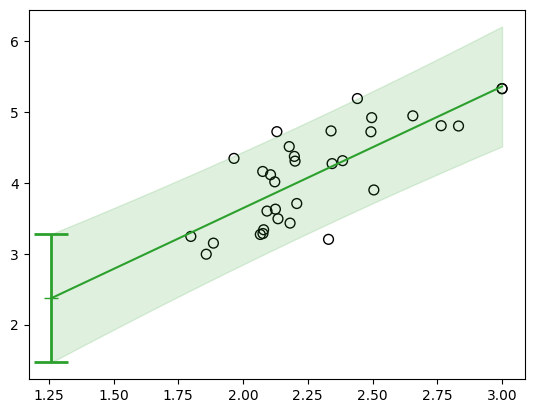

In [80]:
[constrained_CI_1, unconstrained_CI, array_x1, constrained_CI_per_x1
] = compute_confidence_intervals(X1+1., X1_obs, Y+1., 0.90, period_Y, reference_period, return_for_different_x=True)

fig, ax = plt.subplots(1,1)

markers, interval_constrained = display_X_Y_relation(ax, X1+1., Y+1, X1_obs, constrained_CI_1, constrained_CI_per_x1, array_x1)


# Test on the data from the article Cox et al. 2018, to test if we obtain the same result
Their result from Cox et al. 2018 is an ECS in the interval [2.2, 3.4] (66% confidence) when constrained by Ψ. We test if using their data we obtain the same result.

In [31]:
import numpy as np

# data from Extended Data Table 1
# Columns : λ (Wm⁻² K⁻¹), ECS (K), Q₂ₓCO₂/σₙ, Ψ (K)
# Rows : climate models
data = np.array([
    [0.8, 3.8, 8.5, 0.22],
    [1.0, 3.7, 8.3, 0.17],
    [1.2, 2.9, 7.3, 0.19],
    [1.1, 3.3, 8.7, 0.16],
    [0.6, 4.1, 6.1, 0.21],
    [1.4, 2.4, 5.9, 0.15],
    [0.6, 4.6, 7.8, 0.29],
    [1.4, 2.1, 11.9, 0.07],
    [1.0, 2.6, 7.2, 0.16],
    [0.9, 4.7, 11.7, 0.23],
    [1.1, 3.6, 11.9, 0.15],
    [1.2, 2.6, 9.3, 0.09],
    [1.1, 2.8, 7.8, 0.14],
    [1.1, 2.8, 6.9, 0.19],
    [1.8, 2.1, 11.1, 0.12],
    [1.0, 4.1, 8.0, 0.15],
    [1.3, 2.4, 7.1, 0.20],
    [0.8, 4.0, 6.7, 0.36],
    [0.8, 4.1, 8.6, 0.20],
    [1.5, 2.7, 10.2, 0.23],
    [1.2, 2.9, 7.4, 0.14],
    [1.7, 2.3, 11.8, 0.10]
])

# only the 16  first models are used in their article (see their figure 2.b)
ECS = data[:16, 1]
phi = data[:16, 3]

# According to the Extended Data Table 2, HadCrut4 gives an observed value of Ψ of mean 0.13 and standard deviation of 0.016.
phi_obs = np.array(0.13)
var_phi_obs = np.square(0.016)
compute_Cox_confidence_intervals(phi.reshape(-1,1), phi_obs.reshape(-1,1), ECS, 0.66, var_phi_obs)

array([2.23612204, 3.36807833])

We correctly obtained [2.2, 3.4] (with a 66% confidence) !

# Cross-validation (leave-one-out)

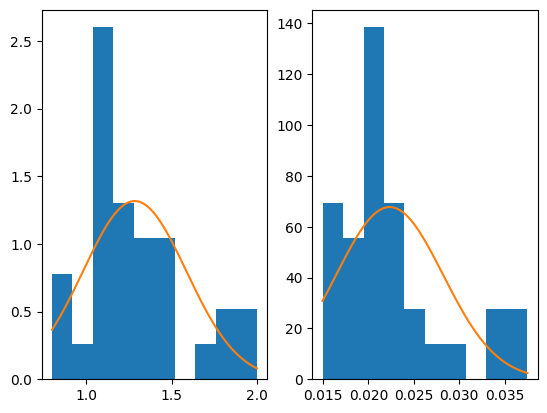

In [32]:

import scipy.stats as stats
x = np.linspace(X1.min(), X1.max(), 2000)
plt.subplot(121)
plt.hist(X1, density=True)
plt.plot(x, stats.norm.pdf(x, np.mean(X1), np.std(X1)), label="unconstrained")

x = np.linspace(X2.min(), X2.max(), 2000)
plt.subplot(122)
plt.hist(X2, density=True)
plt.plot(x, stats.norm.pdf(x, np.mean(X2), np.std(X2)), label="unconstrained")


In [33]:
# boostrap: we make virtually more climate models by taking values from a gaussian with the same mean and variance than the data



In [42]:

Cov_N   = np.cov(X1_bootstrap, rowvar=False, ddof=1)

from sklearn.model_selection import KFold, train_test_split

value_in_interval_perFold_our_method = []
value_in_interval_perFold_method2    = []
value_in_interval_perFold_method3    = []
for i in range(100):

    X_train = np.random.normal(np.mean(X1), np.std(X1), 5)
    X_test  = np.random.normal(np.mean(X1), np.std(X1), 100)
    Y_train = np.random.normal(np.mean(Y), np.std(Y), 5)
    Y_test  = np.random.normal(np.mean(Y), np.std(Y), 100)

    X_train = X_train.reshape(-1,1)
    X_test = X_test.reshape(-1,1)

    
    for x_test, y_test in zip(X_test, Y_test):
        
        # Our method
        [constrained_CI_1, unconstrained_CI
        ] = compute_confidence_intervals(X_train, x_test.reshape(-1,1), Y_train, 0.90, period_X1, reference_period, precomputed_Cov_N=Cov_N, display=False)
        ymin, ymax = constrained_CI_1
        value_in_interval_perFold_our_method.append(np.logical_and(ymin<=y_test, y_test<=ymax))

        # neglecting the limited sample size
        [constrained_CI_1, unconstrained_CI
        ] = compute_confidence_intervals(X_train, x_test.reshape(-1,1), Y_train, 0.90, period_X1, reference_period, precomputed_Cov_N=Cov_N, display=False, neglect_M=True)
        ymin, ymax = constrained_CI_1
        value_in_interval_perFold_method2.append(np.logical_and(ymin<=Y_test, Y_test<=ymax))

        # Method Cox
        constrained_CI = compute_Cox_confidence_intervals(X_train, np.mean(x_test).reshape(-1,1), Y_train, 0.9, Cov_N)
        ymin, ymax = constrained_CI
        value_in_interval_perFold_method3.append(np.logical_and(ymin<=y_test, y_test<=ymax))


In [43]:
np.mean(value_in_interval_perFold_our_method), np.mean(value_in_interval_perFold_method2), np.mean(value_in_interval_perFold_method3)

(0.9045, 0.753837, 0.8172)

In [ ]:
compute_confidence_intervals(X_train, X_test, Y_train, 0.90, period_X1, reference_period, precomputed_Cov_N=Cov_N, display=False)

In [ ]:
np.mean(value_in_interval_perFold_our_method), np.mean(value_in_interval_perFold_method2), np.mean(value_in_interval_perFold_method3)

In [ ]:
plt.hist(X1)

In [ ]:
plt.hist(Y)

# Test with Y that is observable, to compare what we obtain with the real results
We use X1 as Y, and X2 as X

In [44]:
Y_bis     = np.copy(X1).flatten()
Y_bis_obs = np.copy(X1_obs).flatten()

In [45]:
compute_correlation_from_period([1850, 1975], CMIP6_times, CMIP6_global_tas, Y_bis, period_Y)
compute_correlation_from_period([1975, 2014], CMIP6_times, CMIP6_global_tas, Y_bis, period_Y)
compute_correlation_from_period([2015, 2024], CMIP6_times, CMIP6_global_tas, Y_bis, period_Y)

compute_correlation_from_period([1850, 1975], CMIP6_times, CMIP6_global_tas, Y_bis, period_Y, trend=True)
compute_correlation_from_period([1975, 2014], CMIP6_times, CMIP6_global_tas, Y_bis, period_Y, trend=True)
compute_correlation_from_period([2015, 2024], CMIP6_times, CMIP6_global_tas, Y_bis, period_Y, trend=True)

the correlation between the global tas averaged in 2091-2100 and averaged in 1850-1975 is : 0.55
the correlation between the global tas averaged in 2091-2100 and averaged in 1975-2014 is : 0.73
the correlation between the global tas averaged in 2091-2100 and averaged in 2015-2024 is : 1.00
the correlation between the global tas averaged in 2091-2100 and trend in 1850-1975 is : 0.53
the correlation between the global tas averaged in 2091-2100 and trend in 1975-2014 is : 0.58
the correlation between the global tas averaged in 2091-2100 and trend in 2015-2024 is : 0.32


In [46]:
period_X = [1975, 2014]
X        = compute_X_from_period(period_X, CMIP6_times, CMIP6_global_tas).reshape(-1,1)
X_obs    = compute_X_from_period(period_X, time_HadCrut5, global_tas_obs_perRealisation_perTime).reshape(-1,1)

## Compute for each method, the % of observations of Y that falls into the constrained interval

In [47]:
print("Our result:")
[constrained_CI_1, unconstrained_CI, array_x1, constrained_CI_per_x1
] = compute_confidence_intervals(X, X_obs, Y_bis, 0.66, period_X1, reference_period, return_for_different_x=True)

Our result:
66% confidence:
Global temperature at surface in 2015-2024 relative to 1850-1900:
Constrained : [1.34 +- 0.21]
Unconstrained : [1.28 +- 0.30]


In [48]:
constrained_CI_1, np.mean(Y_bis_obs)

(array([1.12955429, 1.55115206]), 1.258913402602645)

In [49]:
Y_bis_obs.min(), Y_bis_obs.max(), len(Y_bis_obs)

(1.1298450124883495, 1.376201230918873, 200)

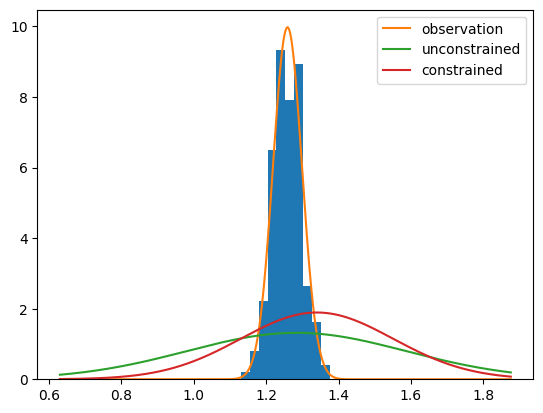

In [50]:
plt.hist(Y_bis_obs, density=True)

import scipy.stats as stats
x = np.linspace(Y_bis_obs.min()-0.5, Y_bis_obs.max()+0.5, 2000)
plt.plot(x, stats.norm.pdf(x, np.mean(Y_bis_obs), np.std(Y_bis_obs)), label="observation")
plt.plot(x, stats.norm.pdf(x, np.mean(Y_bis), np.std(Y_bis)), label="unconstrained")
plt.plot(x, stats.norm.pdf(x, np.mean(constrained_CI_1), np.diff(constrained_CI_1)/2), label="constrained")
plt.legend()

In [51]:
np.mean(Y_bis_obs)

1.258913402602645

# Différentes valeurs estimées pour un fold LOO et une obs: est ce que 90% d'entres elles tombent bien dans l'interval ? Comparaison avec d'autres approches ?

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=len(X1))

pred_values = []
for id_fold, (train_index, test_index) in enumerate(kf.split(X1)):
    X_test  = X1[test_index]
    X_train = X1[train_index]
    Y_test  = Y[test_index]
    Y_train = Y[train_index]

    pred_values.append()


    